# 10 Convolutional Layers

*IMPORTANT*

If you're experiencing issues with this notebook, please update your ```cuDNN``` library:

```
conda activate tf
pip install nvidia-cudnn-cu11==8.9.0.131
```

Once that's done, import the libraries that we are going to use - no surprises so far:

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as image
import tensorflow as tf
from tensorflow import keras

In the networks we have considered so far, all pixels of the input image data have been directly connected to the neurons of the hidden layer. This is fine as long as we are dealing with low-resolution image data, but as soon as we get to higher-quality input data, computational costs rapidly explode. In addition, the network gets even more sensitive to slight variations in the position of features even. Two kinds of special network layers exist to deal with these issues: Convolutional layers and pooling layers. 

Convolutional layers put the C into CNNs and can be depicted as little windows that slide over the input image and apply a small filter kernel matrix (typically) that extracts details that are relevant for the classification. In Tensorflow, we only need to provide the size of the filter kernel matrix as well as the number of filters that shall be applied. The best set of filter matrix elements is learned during the training process.

![Convolutional layers](cnn.jpeg "Title")
Source: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

The ``scipy`` library contains a ``convolve`` function that allows us to easily apply some generic filter kernels with various effects:

In [2]:
# %conda install scipy
from scipy.ndimage import convolve

# A nice selection of kernels: https://en.wikipedia.org/wiki/Kernel_(image_processing)
identity = np.array([[0, 0, 0],[0, 1, 0], [0, 0, 0]])
edge = np.array([[1, 0, -1],[0, 0, 0],[-1, 0, 1]])
sharpen = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
gaussian = np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]]) * 0.0625

What could be more generic than a cat image? Here, we do some extra steps to display the image in its full pixel size assuming a screen pixel density of 100 dpi:

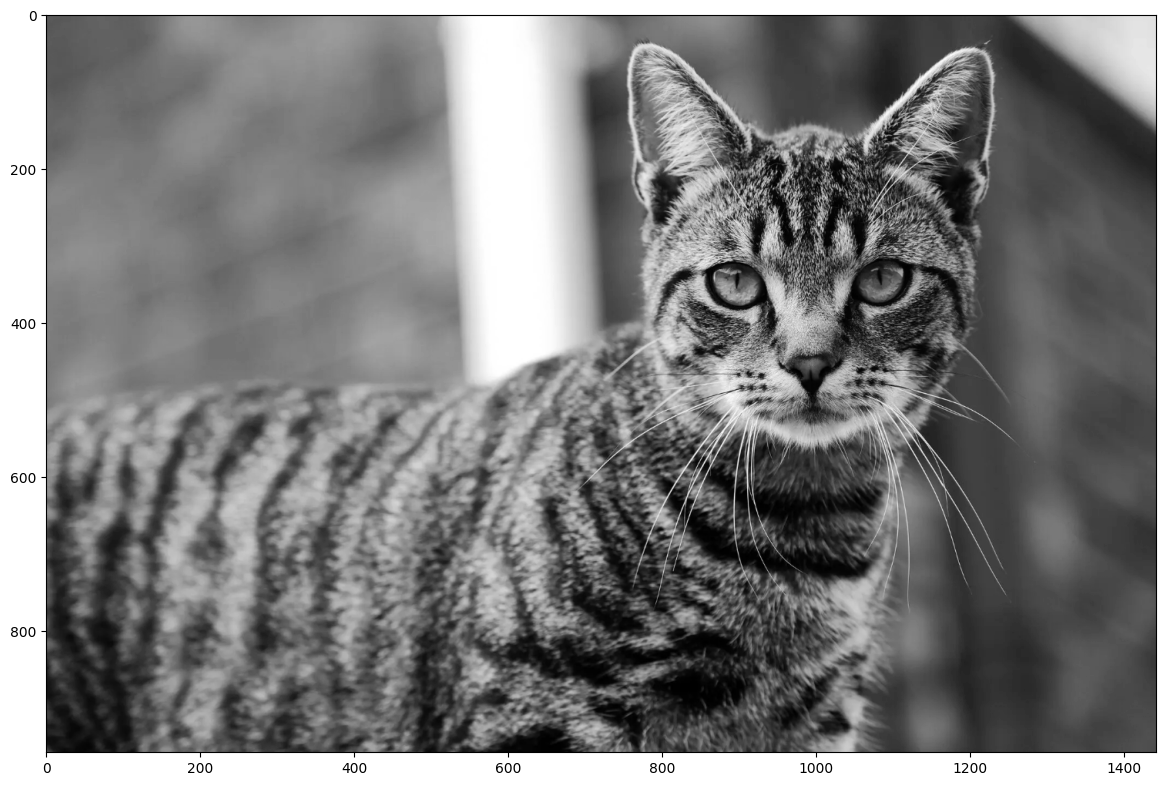

In [3]:
img = np.array(image.open('cat.png').convert('L'))

dpi = 100
height, width = img.shape
figsize = width / dpi, height / dpi

fig = plt.figure(figsize=figsize)
plt.imshow(img, cmap='gray')
plt.show()

As an example, let's apply the Gaussian blur filter to the cat image: 

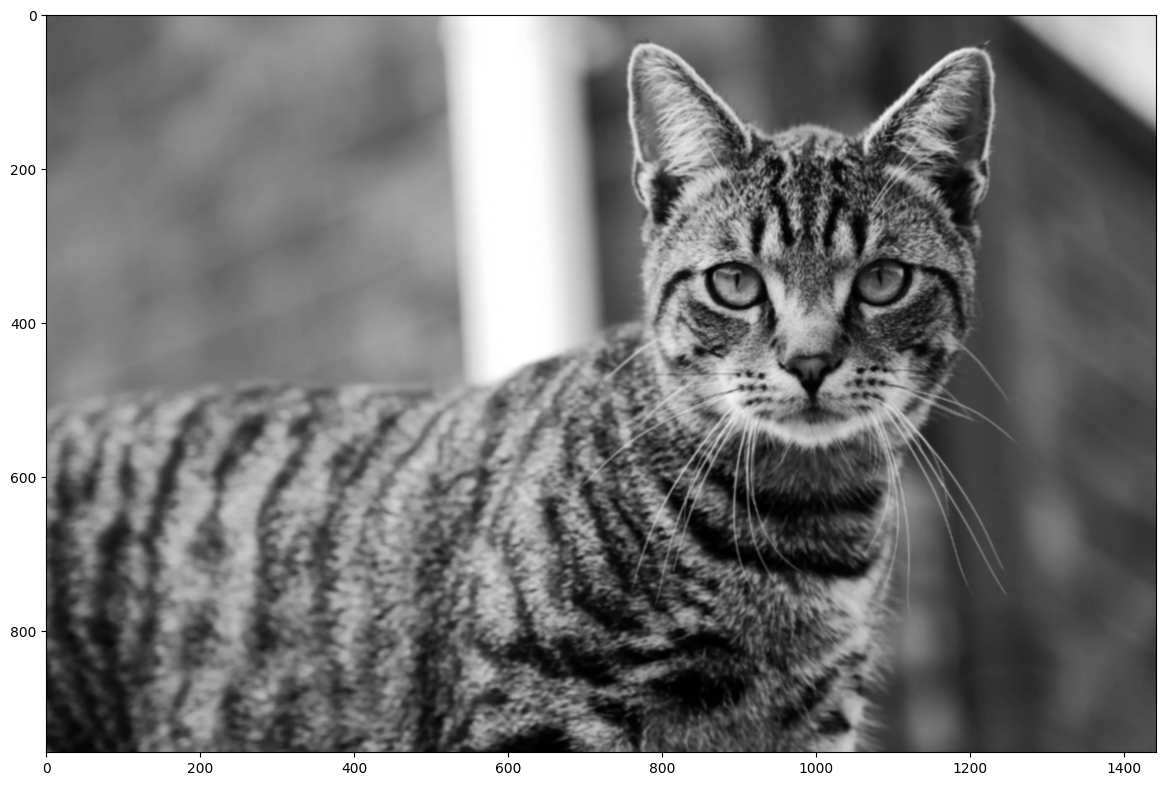

In [4]:
blurImg = convolve(img, gaussian)
blurImg = convolve(blurImg, gaussian)
fig = plt.figure(figsize=figsize)
plt.imshow(blurImg, cmap='gray')
plt.show()

Because of the small size of the filter kernel, the softening effect is quite subtle. Nevertheless, the cat's whiskers and fur are clearly even softer than before. The ``sharpen`` kernel, on the other hand, results in the opposite effect: contrasts and edges are getting more prominent while smooth areas remain unchanged:

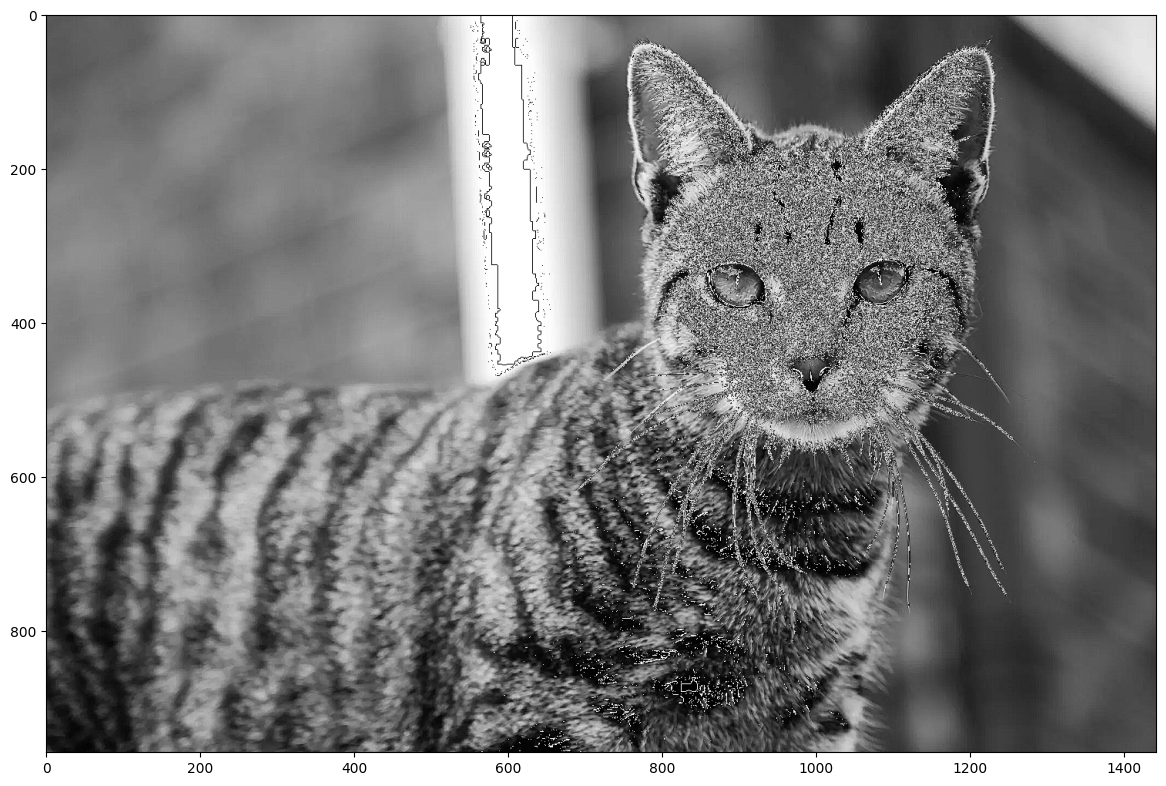

In [5]:
fig = plt.figure(figsize=figsize)
plt.imshow(convolve(img, sharpen), cmap='gray')
plt.show()

Back to neural networks: While we just applied a given filter kernel to a given image, a convolutional layer within a CNN does not have fixed kernel matrix elements. Rather, the network is trained to find which combination of elements works best for the dataset for feature extraction. While this may sound almost too good to be true, there is a hefty price that we are paying. Namely, the number of neural network parameters increases dramatically as does the time for training.

Therefore, after a convolutional layer, one typically applies a pooling layer (MaxPooling or AveragePooling) to reduce the complexity of the network by combining several nodes and only considering either the average or the maximum of their outputs, resulting in a dramatic reduction of data. We will apply these two new layers to a new dataset. That is, a collection of galaxy images that we will use to train a network to distinguish between three basic shapes: Elliptical, spiral and irregular galaxies.

The data itself is a pre-selected subset of the EFIGI survey dataset:

https://www.astromatic.net/projects/efigi

First off, we need to get the images into the notebook. All relevant information is stored in the ``efigi.dat`` file:

In [21]:
data = open("/mnt/share/nnds/galaxies/efigi.dat","r")

names = []
types = []

for line in data:
    fields = line.split(" ")
    names.append( fields[0] )
    types.append( fields[1] )
    
nData = len(names)
imgSize = 128

Elliptical galaxies belong to class 0, spirals to class 1 and irregulars to class 2. Now we can create the data arrays and iterate through the folder:

In [22]:
galaxies = np.zeros((nData,imgSize,imgSize,3))
labels = np.zeros(nData, dtype='int')

for i in range(nData):
    filename = "/mnt/share/nnds/galaxies/png/"+str(names[i])+".png"
    img = image.open(filename)

    imgResized = img.resize(size=(imgSize,imgSize))
    imgArr = np.array(imgResized)

    imgArr = imgArr/255.
    
    galaxies[i,:,:,:] = imgArr 
    labels[i] = types[i]

Do we need to flip the input data range?

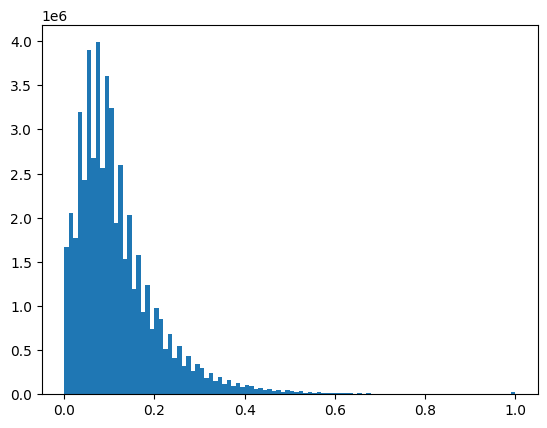

In [8]:
plt.hist(galaxies.flatten(), 100)
plt.show()

Next we need to split the full dataset into a training and a test set. Here, index 955 marks the transition:

In [23]:
split = 955

trainGalaxies = galaxies[:split,:,:,:]
trainLabels = labels[:split]

testGalaxies = galaxies[split+1:nData-1,:,:,:]
testLabels = labels[split+1:nData-1]

To avoid having to go through all this again, we store the data as ``*.npz`` files:

In [28]:
np.save("/home/nnds1b/lab/lab_10/galaxies/trainGalaxies.npy", trainGalaxies)
np.save("/home/nnds1b/lab/lab_10/galaxies/trainLabels.npy", trainLabels)

np.save("/home/nnds1b/lab/lab_10/galaxies/testGalaxies.npy", testGalaxies)
np.save("/home/nnds1b/lab/lab_10/galaxies/testLabels.npy", testLabels)

We are ready to configure the network. The configuration we are using is based on a conference proceeding by an astrophysics group from Egypt (Khalifa et al 2017, https://arxiv.org/abs/1709.02245). We start with a feature extraction layer that uses a convolutional layer with 96 filters (8x8 filter kernel each) and a pooling layer that bins every 3x3 pixels to a single output:

In [11]:
galNet = keras.Sequential([
    keras.layers.Conv2D(96, (6, 6), activation='relu', input_shape=(imgSize,imgSize,3)), # During the training process, filter(s) that are optimal for the extraction of the features will be determined
    keras.layers.MaxPooling2D(pool_size=(3,3)), # Maxpooling means we're only considering the strongest features (the feature maps with stronger features)
    keras.layers.Flatten(),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])

2024-01-09 12:15:28.293847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 12:15:28.296848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-09 12:15:28.296968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Let's take a look at the structure of our network:

In [12]:
galNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 123, 96)      10464     
                                                                 
 max_pooling2d (MaxPooling2  (None, 41, 41, 96)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 161376)            0         
                                                                 
 dense (Dense)               (None, 24)                3873048   
                                                                 
 dense_1 (Dense)             (None, 3)                 75        
                                                                 
Total params: 3883587 (14.81 MB)
Trainable params: 3883587 (14.81 MB)
Non-trainable params: 0 (0.00 Byte)
________________

Time to compile the model and train it. After every training epoch, the network performance is evalulated and stored.

In [13]:
galNet.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = galNet.fit(trainGalaxies, trainLabels, validation_data=(testGalaxies, testLabels), epochs=50)

Epoch 1/50


2024-01-09 12:15:29.059731: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8900
2024-01-09 12:15:29.139343: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-09 12:15:29.270242: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-09 12:15:29.316666: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2620044c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-09 12:15:29.316691: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-01-09 12:15:29.323096: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-09 12:15:29.433970: I ./tensorflow/compiler/jit/device_comp

30/30 [==============================] - 2s 24ms/step - loss: 1.0103 - accuracy: 0.4974 - val_loss: 0.8130 - val_accuracy: 0.4958
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6321 - accuracy: 0.6168 - val_loss: 0.6005 - val_accuracy: 0.5798
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.5372 - accuracy: 0.6754 - val_loss: 0.4991 - val_accuracy: 0.8067
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.4582 - accuracy: 0.8314 - val_loss: 0.4641 - val_accuracy: 0.8235
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.4133 - accuracy: 0.8293 - val_loss: 0.5356 - val_accuracy: 0.7227
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.3591 - accuracy: 0.8450 - val_loss: 0.4856 - val_accuracy: 0.7647
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.3380 - accuracy: 0.8597 - val_loss: 0.3391 - val_accuracy: 0.8487
Epoch 8/50
30/30 [======

The history object contains a history attribut that stores some of the training metrics:

In [14]:
print(dir(history))
print(type(history.history))
print(history.history.keys())

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_chief_worker_only', '_implements_predict_batch_hooks', '_implements_test_batch_hooks', '_implements_train_batch_hooks', '_keras_api_names', '_keras_api_names_v1', '_supports_tf_logs', 'epoch', 'history', 'model', 'on_batch_begin', 'on_batch_end', 'on_epoch_begin', 'on_epoch_end', 'on_predict_batch_begin', 'on_predict_batch_end', 'on_predict_begin', 'on_predict_end', 'on_test_batch_begin', 'on_test_batch_end', 'on_test_begin', 'on_test_end', 'on_train_batch_begin', 'on_train_batch_end', 'on_train_begin', 'on_train_end', 'params', 'set_model', 'set_params', 'validation_data']
<class 'dict'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'

Let's evaluate the training process by looking at a plot of the evolution of the performance:

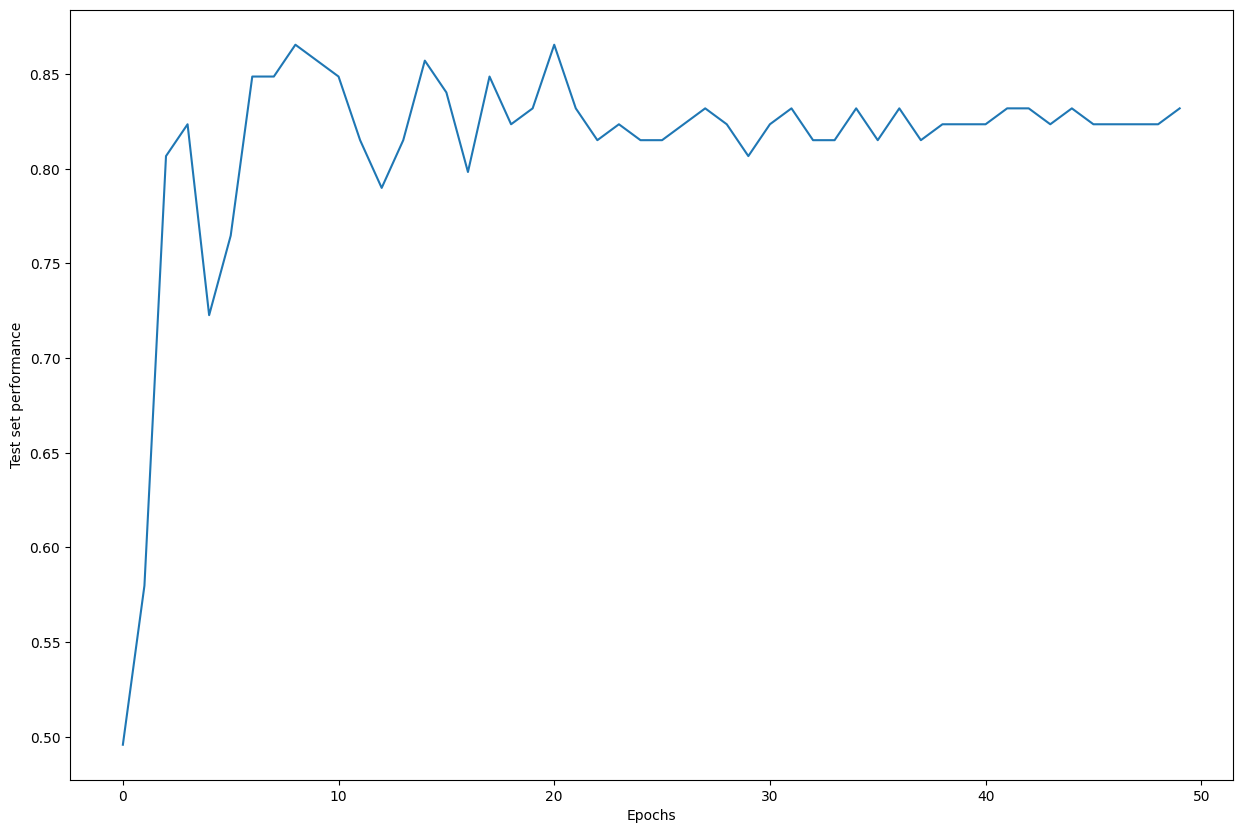

In [15]:
plt.figure(figsize=(15,10))
plt.xlabel("Epochs")
plt.ylabel("Test set performance")
plt.plot(history.history['val_accuracy'])
plt.savefig("galnet_performance.pdf")
plt.show()

Apparently, we're getting into the overfit regime. Are there ways to deal with that and train complex networks even further? More on that next week ...

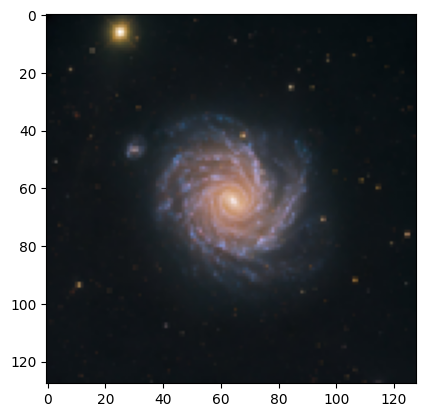

In [16]:
img = image.open("/mnt/share/nnds/galaxies/ngc1232b.jpg")

imgResized = img.resize(size=(imgSize,imgSize))
imgArr = np.array(imgResized)

imgArr = imgArr/255.

plt.imshow(imgArr)
plt.show()

In [17]:
imgArrExp = np.expand_dims(imgArr,axis=0)
print(imgArrExp.shape)

(1, 128, 128, 3)


In [18]:
pred = galNet.predict(imgArrExp)
print(pred)

1/1 [==============================] - 0s 63ms/step
[[3.8618025e-10 1.0000000e+00 6.1962436e-13]]


In [19]:
galNet.save('galNet.h5')

/home/nnds1b/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
